In [386]:
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

dyadic = pd.read_csv('Dyadic_v25_1.csv')
aid = pd.read_csv('micFINAL.csv')
term = pd.read_csv('UCDPConflictTerminationDataset_v4_2024_Dyad.csv')

https://ucdp.uu.se/downloads/index.html#dyadic
https://ucdp.uu.se/downloads/monadterm/UCDPConflictTerminationDataset_v4_2024_Codebook.pdf
https://ucdp.uu.se/downloads/dyadic/ucdp-dyadic-251.pdf
https://ucdp.uu.se/downloads/aidmilc/ucdp_mic_codebook.pdf


Research Question: how do interstate conflicts evolve over time; what trends do we see with respect to region, motivations, and intensity? How do they end, and how do 3rd party interventions affect this process?



In [387]:
aid['start_year'] = pd.to_datetime(aid['start_event'], errors='coerce').dt.year
aid['end_year'] = pd.to_datetime(aid['end_event'], errors='coerce').dt.year

aid_types = ['peacekeeping', 'good_office', 'fact_finding', 'permanent_observers']

# --- Expand to conflict-year level ---
aid_years = []
for _, row in aid.iterrows():
    if pd.notnull(row['start_year']) and pd.notnull(row['end_year']):
        for yr in range(int(row['start_year']), int(row['end_year']) + 1):
            entry = {
                'conflict_id': row['conflict_id'],
                'year': yr,
                'foreign_intervention': 1,
                'num_countries_aiding': row.get('third_states_no', 0)
            }
            # Add one-hot encoded type columns
            for col in aid_types:
                entry[col] = row.get(col, 0)
            aid_years.append(entry)


aid_expanded = pd.DataFrame(aid_years)

# cont_cols = [c for c in aid_expanded.columns if aid_expanded[c].dtype in ['float32','float64','int32','int64'] and c not in ['region_code'] ]
# print('Summary stats for continuous columns:')
# display(aid_expanded[cont_cols].describe().T)

In [388]:
dyadic['region_single'] = dyadic['region'].apply(lambda x: x.split(',')[0])

print(dyadic['region_single'].unique())
dyadic_yearly = (
    dyadic.groupby(['conflict_id', 'year'])
          .agg(
              battle_deaths = ('intensity_level', 'mean'),
              num_dyads     = ('dyad_id', 'nunique'),
              incompatibility_mode = ('incompatibility',lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
              region=('region_single', lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])

          )
          .reset_index()
)

dyadic_yearly = dyadic_yearly.merge (
    aid_expanded,
    on=['conflict_id', 'year'],
    how='left'
  ).fillna({'foreign_intervention': 0})



cont_cols = [c for c in dyadic_yearly.columns if dyadic_yearly[c].dtype in ['float32','float64','int32','int64'] and c not in ['region_code'] ]
print('Summary stats for continuous columns:')
display(dyadic_yearly[cont_cols].describe().T)

['4' '2' '3' '1' '5']
Summary stats for continuous columns:
Summary stats for continuous columns:


,count,mean,std,min,25%,50%,75%,max
conflict_id,2752.0,1567.511991,3892.548767,200.0,253.0,309.0,374.0,16379.0
year,2752.0,1992.130451,21.178253,1946.0,1977.0,1993.0,2011.0,2024.0
battle_deaths,2752.0,1.214751,0.396327,1.0,1.0,1.0,1.0,2.0
num_dyads,2752.0,1.247093,0.649910,1.0,1.0,1.0,1.0,8.0
incompatibility_mode,2752.0,1.456032,0.517481,1.0,1.0,1.0,2.0,3.0
foreign_intervention,2752.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
num_countries_aiding,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peacekeeping,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
good_office,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fact_finding,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:

term_yearly = (
    term.groupby(['conflict_id', 'year'])
          .agg(
              battle_deaths = ('intensity_level', 'mean'),
              num_dyads     = ('dyad_id', 'nunique'),
              mode_outcome = ('d_outcome',
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
          )
          .reset_index()
)

term_yearly = (
    term.groupby(['conflict_id', 'year'])
          .agg({
              'intensity_level': 'mean',     # total battle deaths that year
              'dyad_id': 'nunique',  # number of dyads active
          })
          .reset_index()
          .rename(columns={'best_est': 'battle_deaths'})
            .rename(columns={
              'best_est': 'battle_deaths',
              'dyad_id': 'num_dyads'
          })
)

merged = dyadic_yearly.merge( 
    term[['conflict_id', 'year' ,'d_ep_endyear','d_epterm']], 
    on=['conflict_id', 'year'],
    how='left')
merged['d_epterm'] = merged['d_epterm'].astype('float32')

In [390]:
df = merged.copy()
df = merged.dropna(subset=['d_epterm']).copy()
# Create integer codes for 'region' for embedding (reserve 0 for padding)
df['region_code'] = df['region'].astype('category').cat.codes + 1
num_regions = int(df['region_code'].max()) + 1  # includes padding id 0
print('num_regions (including padding):', num_regions)
print(df[df['conflict_id'] == 200][['region','region_code']].head())

num_regions (including padding): 6
  region  region_code
0      5            5
1      5            5
2      5            5
3      5            5


# Data Exploration: Overview of our dataset

In [391]:
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
print('Dtypes:', df.dtypes)
print('Missing values per column:')
print(df.isnull().sum())
print('Sample rows:')
display(df.head(3))

Shape: (3362, 15)
Columns: ['conflict_id', 'year', 'battle_deaths', 'num_dyads', 'incompatibility_mode', 'region', 'foreign_intervention', 'num_countries_aiding', 'peacekeeping', 'good_office', 'fact_finding', 'permanent_observers', 'd_ep_endyear', 'd_epterm', 'region_code']
Dtypes: conflict_id               int64
year                      int64
battle_deaths           float64
num_dyads                 int64
incompatibility_mode      int64
region                   object
foreign_intervention    float64
num_countries_aiding    float64
peacekeeping            float64
good_office             float64
fact_finding            float64
permanent_observers     float64
d_ep_endyear            float64
d_epterm                float32
region_code                int8
dtype: object
Missing values per column:
conflict_id                0
year                       0
battle_deaths              0
num_dyads                  0
incompatibility_mode       0
region                     0
foreign_intervention 

,conflict_id,year,battle_deaths,num_dyads,incompatibility_mode,region,foreign_intervention,num_countries_aiding,peacekeeping,good_office,fact_finding,permanent_observers,d_ep_endyear,d_epterm,region_code
0,200,1946,2.0,1,2,5,0.0,NaN,NaN,NaN,NaN,NaN,1946.0,1.0,5
1,200,1949,1.0,1,2,5,0.0,NaN,NaN,NaN,NaN,NaN,1949.0,1.0,5
2,200,1952,1.0,1,2,5,0.0,NaN,NaN,NaN,NaN,NaN,1952.0,1.0,5


In [392]:
# Diagnostics: check dyadic_yearly vs aid_expanded before merging
print('dyadic_yearly exists?', 'dyadic_yearly' in globals())
print('aid_expanded exists?', 'aid_expanded' in globals())
if 'dyadic_yearly' in globals():
    print('dyadic_yearly.shape ->', dyadic_yearly.shape)
    print(dyadic_yearly.dtypes[['conflict_id','year']])
    print(dyadic_yearly.head(3))
if 'aid_expanded' in globals():
    print('aid_expanded.shape ->', aid_expanded.shape)
    # show dtypes if columns present
    for c in ['conflict_id','year']:
        if c in aid_expanded.columns:
            print('aid_expanded', c, 'dtype ->', aid_expanded[c].dtype)
    print(aid_expanded.head(5))

# Check null keys and uniqueness
if 'aid_expanded' in globals() and {'conflict_id','year'}.issubset(aid_expanded.columns):
    print('aid_expanded nulls in keys:', aid_expanded['conflict_id'].isnull().sum(), aid_expanded['year'].isnull().sum())
if 'dyadic_yearly' in globals() and {'conflict_id','year'}.issubset(dyadic_yearly.columns):
    print('dyadic_yearly nulls in keys:', dyadic_yearly['conflict_id'].isnull().sum(), dyadic_yearly['year'].isnull().sum())

# Try an inner join to count matches
if 'dyadic_yearly' in globals() and 'aid_expanded' in globals():
    on_cols = ['conflict_id','year']
    inner = dyadic_yearly.merge(aid_expanded, on=on_cols, how='inner')
    print('Inner-join matched rows:', inner.shape[0])
    outer = dyadic_yearly.merge(aid_expanded, on=on_cols, how='outer', indicator=True)
    print('Outer join sizes: dyadic_only, both, aid_only')
    print(outer['_merge'].value_counts().to_dict())
    # show a few examples of aid rows not matching dyadic_yearly
    aid_keys = set((str(x),str(y)) for x,y in aid_expanded[['conflict_id','year']].dropna().astype(str).itertuples(index=False,name=None))
    dyad_keys = set((str(x),str(y)) for x,y in dyadic_yearly[['conflict_id','year']].dropna().astype(str).itertuples(index=False,name=None))
    diff = list(aid_keys - dyad_keys)[:10]
    print('Sample (conflict_id,year) in aid but not in dyadic_yearly (up to 10):', diff)

# Suggest fix if types mismatch
if 'dyadic_yearly' in globals() and 'aid_expanded' in globals():
    print('dyadic_yearly.conflict_id dtype:', dyadic_yearly['conflict_id'].dtype, 'aid_expanded.conflict_id dtype:', aid_expanded['conflict_id'].dtype)
    print('dyadic_yearly.year dtype:', dyadic_yearly['year'].dtype, 'aid_expanded.year dtype:', aid_expanded['year'].dtype)
    print('If dtypes differ, ensure both are same type (e.g., int) before merging:')
    print(
)
    print(
)

dyadic_yearly exists? True
aid_expanded exists? True
dyadic_yearly.shape -> (2752, 12)
conflict_id    int64
year           int64
dtype: object
   conflict_id  year  battle_deaths  num_dyads  incompatibility_mode region  \
0          200  1946            2.0          1                     2      5   
1          200  1949            1.0          1                     2      5   
2          200  1952            1.0          1                     2      5   

   foreign_intervention  num_countries_aiding  peacekeeping  good_office  \
0                   0.0                   NaN           NaN          NaN   
1                   0.0                   NaN           NaN          NaN   
2                   0.0                   NaN           NaN          NaN   

   fact_finding  permanent_observers  
0           NaN                  NaN  
1           NaN                  NaN  
2           NaN                  NaN  
aid_expanded.shape -> (3664, 8)
aid_expanded conflict_id dtype -> float64
aid_e

In [393]:
# Value counts for key categorical columns
for col in ['region', 'region_code', 'incompatibility_mode']:
    if col in df.columns:
        print(f'Value counts for {col}:')
        print(df[col].value_counts(dropna=False).head(10))
        print()


Value counts for region:
region
3    1309
4    1110
2     482
5     277
1     184
Name: count, dtype: int64

Value counts for region_code:
region_code
3    1309
4    1110
2     482
5     277
1     184
Name: count, dtype: int64

Value counts for incompatibility_mode:
incompatibility_mode
1    1694
2    1645
3      23
Name: count, dtype: int64



In [394]:
# Summary stats for continuous columns
cont_cols = [c for c in df.columns if df[c].dtype in ['float32','float64','int32','int64'] and c not in ['region_code'] ]
print('Summary stats for continuous columns:')
display(df[cont_cols].describe().T)

Summary stats for continuous columns:


,count,mean,std,min,25%,50%,75%,max
conflict_id,3362.0,1324.840274,3510.036759,200.0,259.0,308.0,356.750000,16292.0
year,3362.0,1991.781678,20.249777,1946.0,1978.0,1992.0,2009.000000,2023.0
battle_deaths,3362.0,1.210589,0.376989,1.0,1.0,1.0,1.333333,2.0
num_dyads,3362.0,1.591612,1.110964,1.0,1.0,1.0,2.000000,8.0
incompatibility_mode,3362.0,1.502974,0.513568,1.0,1.0,1.0,2.000000,3.0
foreign_intervention,3362.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
num_countries_aiding,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peacekeeping,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
good_office,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fact_finding,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [395]:

# Continuous features (we will embed categorical 'region' separately)
features_cont = [
    'battle_deaths',
    'num_dyads',
    'foreign_intervention',
    'num_countries_aiding',
    'peacekeeping',
    'good_office',
    'fact_finding',
    'permanent_observers',
    'incompatibility_mode',
]

# Ensure continuous features are numeric
for col in features_cont:
    df[col] = df[col].fillna(0).astype(np.float32)

target = 'd_epterm'

X_cont_seq, X_region_seq, y_labels = [], [], []

for conflict_id, group in df.groupby('conflict_id'):
    X_cont = group[features_cont].values.astype(np.float32)
    X_region = group['region_code'].values.astype(np.int64)
    y = group[target].values
    for t in range(len(X_cont) - 1):
        X_cont_seq.append(X_cont[:t+1])   # continuous features history
        X_region_seq.append(X_region[:t+1]) # categorical region history
        y_labels.append(y[t+1])


In [396]:
def pad_sequences_torch(sequences, maxlen=15, padding="pre", dtype=torch.float32):
    n_samples = len(sequences)
    n_features = len(sequences[0][0])
    padded = torch.zeros((n_samples, maxlen, n_features), dtype=dtype)

    for i, seq in enumerate(sequences):
        seq = torch.tensor(seq, dtype=dtype)
        length = min(len(seq), maxlen)

        if padding == "pre":
            padded[i, -length:, :] = seq[-length:, :]
        else:
            padded[i, :length, :] = seq[:length, :]

    return padded


In [397]:
scaler = StandardScaler()
# Clean continuous sequences (replace NaNs with 0 for scaling step)
X_cont_clean = [np.nan_to_num(seq, nan=0.0) for seq in X_cont_seq]
all_steps = np.concatenate(X_cont_clean, axis=0) if len(X_cont_clean) > 0 else np.empty((0, len(features_cont)))
scaler.fit(all_steps)
X_cont_scaled = [scaler.transform(seq) for seq in X_cont_clean]

lengths = [len(s) for s in X_cont_seq]
MAXLEN = int(np.percentile(lengths, 95)) if len(lengths) > 0 else 1

# Pad continuous sequences (returns torch tensor)
X_cont_padded = pad_sequences_torch(X_cont_scaled, maxlen=MAXLEN)

# Pad categorical (region) sequences with padding id 0
def pad_cat(sequences, maxlen=MAXLEN, padding='pre', dtype=torch.long):
    padded = torch.zeros((len(sequences), maxlen), dtype=dtype)
    for i, seq in enumerate(sequences):
        seq = torch.tensor(seq, dtype=dtype)
        L = min(len(seq), maxlen)
        if padding == 'pre':
            padded[i, -L:] = seq[-L:]
        else:
            padded[i, :L] = seq[:L]
    return padded

X_region_padded = pad_cat(X_region_seq, maxlen=MAXLEN)
y_tensor = torch.tensor(y_labels, dtype=torch.float32)


In [398]:
# Split continuous, categorical, and labels together
X_train_cont, X_test_cont, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_cont_padded, X_region_padded, y_tensor, test_size=0.2, random_state=42
)


In [399]:
# Create datasets that include continuous and categorical tensors
train_ds = TensorDataset(X_train_cont, X_train_cat, y_train)
test_ds  = TensorDataset(X_test_cont, X_test_cat, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)



In [400]:
import torch.nn as nn

class LSTMWithEmb(nn.Module):
    def __init__(self, n_cont, num_regions, emb_dim=16, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_regions, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(n_cont + emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, cont_x, cat_x):
        # cont_x: (batch, seq_len, n_cont), cat_x: (batch, seq_len)
        emb = self.embedding(cat_x)                       # (batch, seq_len, emb_dim)
        x = torch.cat([cont_x, emb], dim=2)             # concat features
        out, _ = self.lstm(x)
        last = out[:, -1, :]                            # final timestep
        return self.sigmoid(self.fc(last)).squeeze(-1)


In [401]:
input_dim = X_cont_padded.shape[2]
# num_regions was defined earlier when we created 'region_code' (includes padding id)
model = LSTMWithEmb(n_cont=input_dim, num_regions=num_regions, emb_dim=16, hidden_dim=64)


In [402]:
print(torch.isnan(X_padded).sum())
print(torch.isinf(X_padded).sum())
print(torch.isnan(y_tensor).sum())
print(X_padded[1000])
print(y_tensor[0])



tensor(0)
tensor(0)
tensor(0)
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6624, -0.6880,  0.0000,  ..., -0.9072, -0.5715, -0.3642],
        [-0.6624, -0.6880,  0.0000,  ..., -0.9072, -0.5715, -0.3642],
        [ 1.9724, -0.6880,  0.0000,  ..., -0.9072, -0.5715, -0.3642]])
tensor(1.)


n sequences: 3062
length percentiles (50/75/90/95/99): [ 13.  31.  54.  72. 111.]


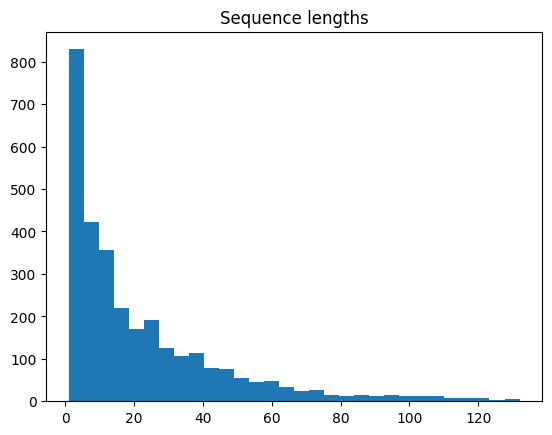

Fraction of all elements that are zero: 0.834
Number of sequences all-zero: 0
Zero rate per feature (first 10): [0.7101885 0.7101885 1.        1.        1.        1.        1.
 1.        0.7101885 0.7101885]
raw seq length: 1
raw seq (first 3 rows):
 [[2. 1. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1.]]
scaled seq (first 3 rows):
 [[ 1.9723763  -0.68796     0.          0.          0.          0.
   0.          0.          0.8240546  -0.10685689 -0.45885715 -0.9071801
  -0.57153547  2.7456965 ]]
padded last 5 timesteps:
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0

In [403]:
# 1) distribution of raw sequence lengths
lengths = [len(s) for s in X_seq]
import numpy as np
print("n sequences:", len(lengths))
print("length percentiles (50/75/90/95/99):", np.percentile(lengths, [50,75,90,95,99]))

# 2) histogram
import matplotlib.pyplot as plt
plt.hist(lengths, bins=30); plt.title("Sequence lengths"); plt.show()

# 3) fraction of zeros in padded tensor
import torch
frac_zeros = (X_padded == 0).float().mean().item()
print(f"Fraction of all elements that are zero: {frac_zeros:.3f}")

# 4) how many sequences are entirely zero after padding
all_zero_seq_count = (X_padded.abs().sum(dim=(1,2)) == 0).sum().item()
print("Number of sequences all-zero:", all_zero_seq_count)

# 5) per-feature zero rate (average across samples & timesteps)
zero_rate_per_feature = ((X_padded == 0).float().mean(dim=(0,1))).cpu().numpy()
print("Zero rate per feature (first 10):", zero_rate_per_feature[:10])

# 6) compare a raw sequence, scaled, and padded version (example index 0)
print("raw seq length:", len(X_seq[0]))
print("raw seq (first 3 rows):\n", np.array(X_seq[0])[:3])
print("scaled seq (first 3 rows):\n", np.array(X_scaled[0])[:3])
print("padded last 5 timesteps:\n", X_padded[0, -5:, :])

In [404]:
for xb_cont, xb_cat, yb in train_loader:
    # xb_cont: (batch, seq_len, n_cont), xb_cat: (batch, seq_len)
    print('cont:', xb_cont.dtype, xb_cont.min(), xb_cont.max())
    print('cat :', xb_cat.dtype, xb_cat.min(), xb_cat.max())
    print('y   :', yb.dtype, yb.min(), yb.max())
    break


cont: torch.float32 tensor(-1.2052) tensor(3.2547)
cat : torch.int64 tensor(0) tensor(5)
y   : torch.float32 tensor(0.) tensor(1.)


In [405]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

for epoch in range(10):
    model.train()
    for xb_cont, xb_cat, yb in train_loader:
        xb_cont = xb_cont.float()
        xb_cat = xb_cat.long()
        yb = yb.float()
        optimizer.zero_grad()
        preds = model(xb_cont, xb_cat).flatten()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    print("Epoch", epoch, "loss", float(loss))


Epoch 0 loss 0.6080752015113831
Epoch 1 loss 0.6087495684623718
Epoch 1 loss 0.6087495684623718
Epoch 2 loss 0.6001248359680176
Epoch 2 loss 0.6001248359680176
Epoch 3 loss 0.7034381031990051
Epoch 3 loss 0.7034381031990051
Epoch 4 loss 0.5211556553840637
Epoch 4 loss 0.5211556553840637
Epoch 5 loss 0.439835786819458
Epoch 5 loss 0.439835786819458
Epoch 6 loss 0.6282969117164612
Epoch 6 loss 0.6282969117164612
Epoch 7 loss 0.3966918885707855
Epoch 7 loss 0.3966918885707855
Epoch 8 loss 0.495699942111969
Epoch 8 loss 0.495699942111969
Epoch 9 loss 0.3990415036678314
Epoch 9 loss 0.3990415036678314


Final Project Ideas/Analysis 

